Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [12, 8]})

# Chapter 4 - Exploring Financial Time Series Data

## 4.1 Outlier detection using rolling statistics

### How to do it...

1. Import the libraries:

In [46]:
import pandas as pd
import yfinance as yf

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

In [47]:
df = yf.download("TSLA",
                 start="2019-01-01",
                 end="2020-12-31",
                 progress=False)

df["rtn"] = df["Close"].pct_change()
df = df[["rtn"]].copy()
df.head()


Price,rtn
Ticker,
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164


3. Calculate the rolling mean and standard deviation:

In [48]:
df_rolling = df[["rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()

4. Join the rolling data back to the initial DataFrame:

In [49]:
#df = df.join(df_rolling)
df.head(25)

Price,rtn
Ticker,
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164
2019-01-09,0.009483
2019-01-10,0.019023
2019-01-11,0.006638


In [50]:
df = df.join(df_rolling)
df.columns=['rtn', 'mean', 'std']

5. Calculate the upper and lower thresholds:

In [51]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

6. Identify the outliers using the previously calculated thresholds:

In [52]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)

7. Plot the returns together with the thresholds and mark the outliers:

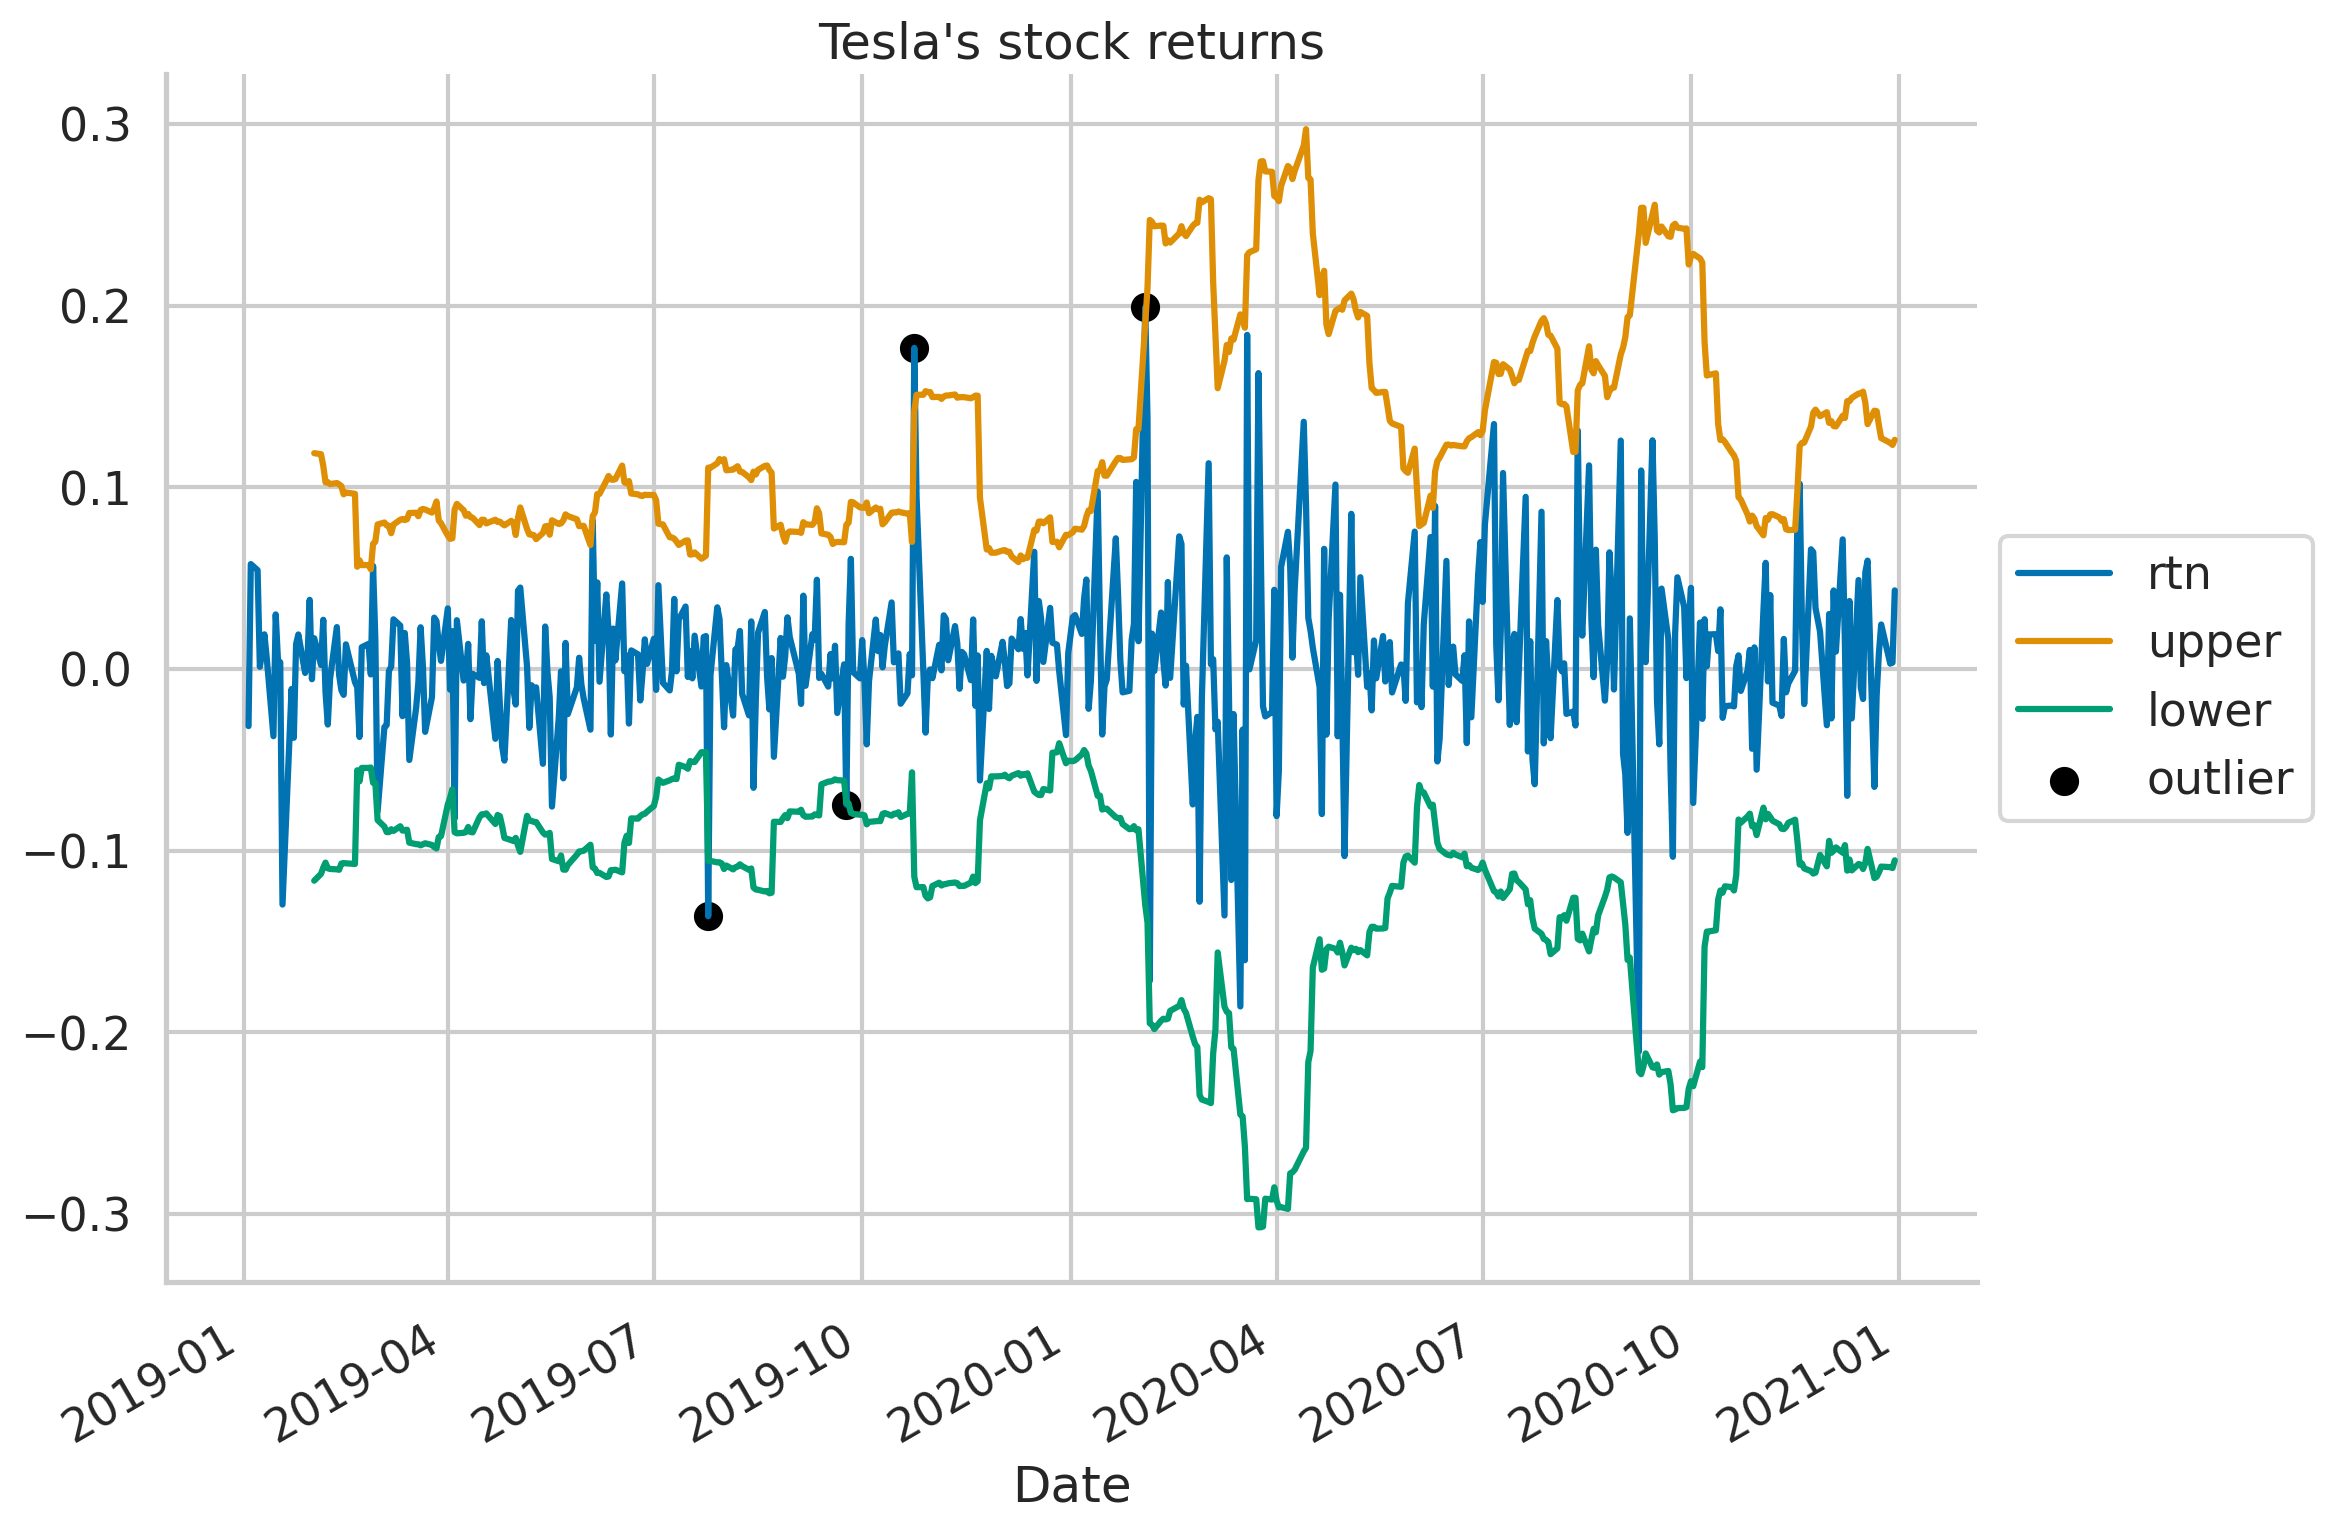

In [53]:
fig, ax = plt.subplots()

df[["rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "rtn"],
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_1", dpi=200)

## Задание 1
Визуализировать скользящие среднии стоимости акций компании Тесла при разных значениях в параметре `windows = np.arange(5, 30, 5)`.

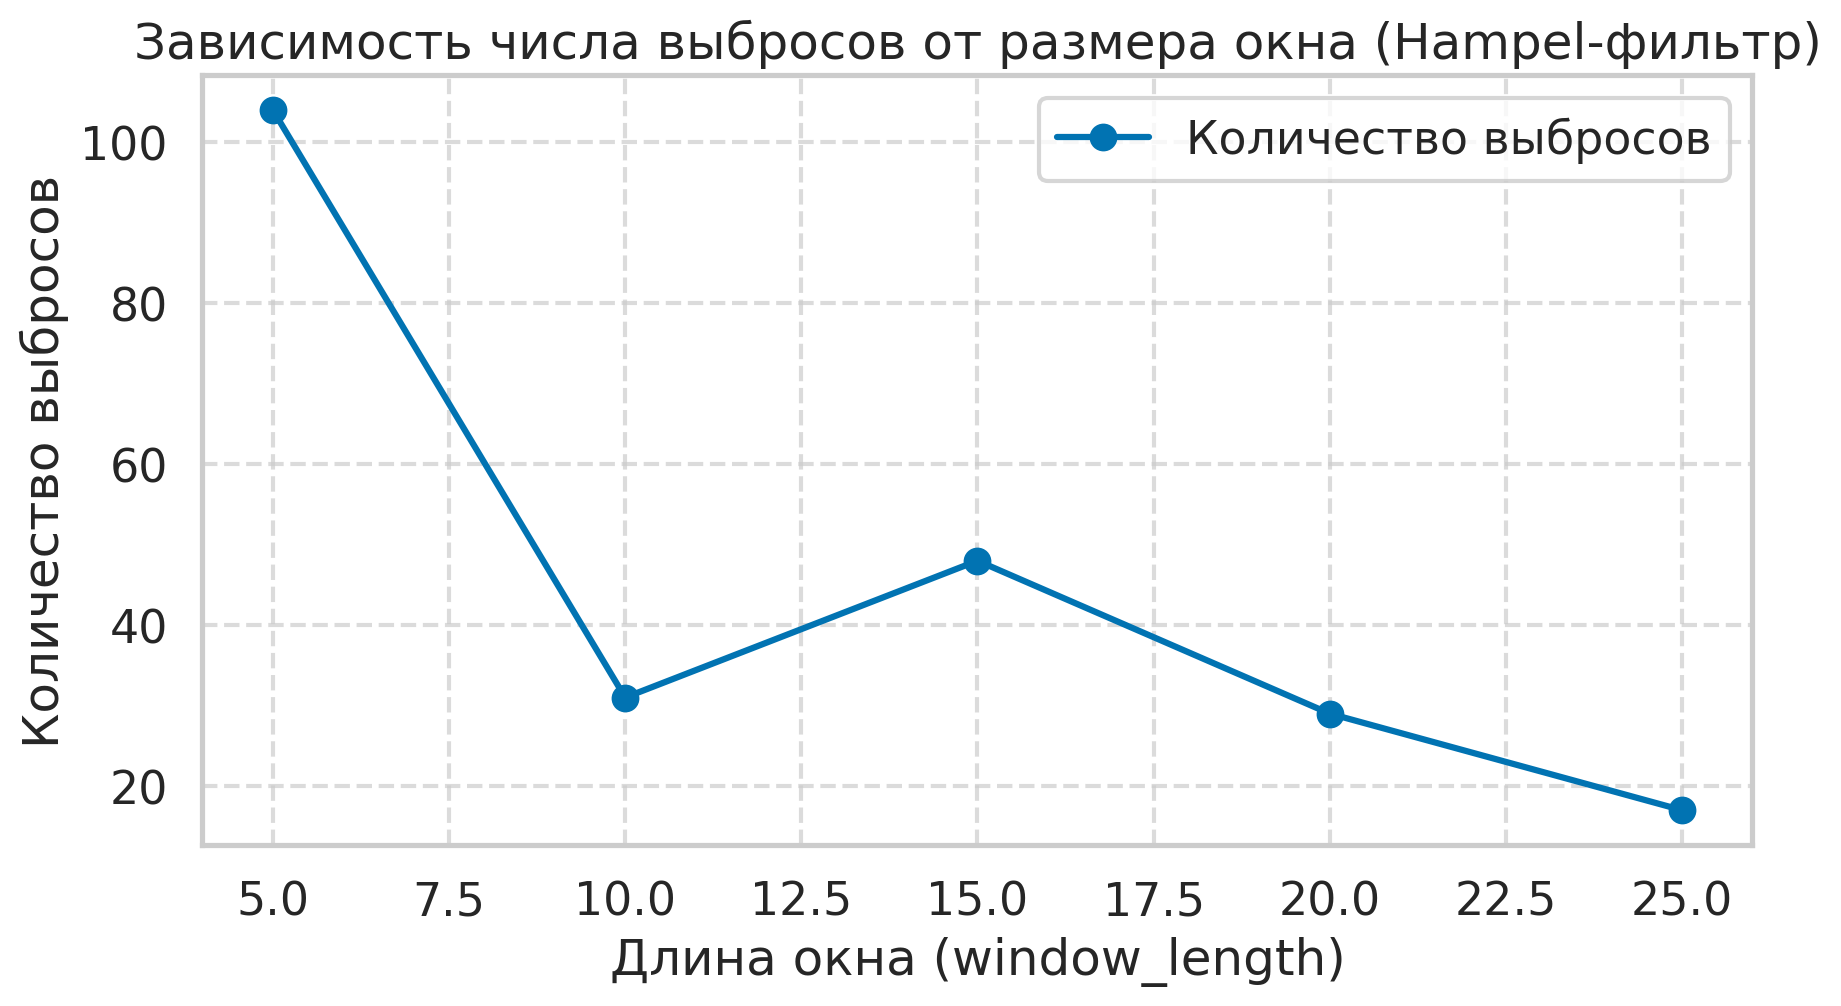

In [54]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
# Загрузка данных
df1 = yf.download("TSLA", start="2020-01-01", end="2023-01-01", progress=False)["Close"]

# Функция Hampel-фильтра
def hampel_filter(data, window_length, k=3):
    median = data.rolling(window=window_length, center=True).median()
    mad = 1.4826 * np.abs(data - median).rolling(window=window_length, center=True).median()
    outliers = np.abs(data - median) > k * mad
    return outliers

# Исследуем зависимость от window_length
window_lengths = np.arange(5, 30, 5)
outliers_counts = []

for w in window_lengths:
    outliers = hampel_filter(df1, window_length=w, k=3)
    outliers_counts.append(outliers.sum())

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(window_lengths, outliers_counts, 'bo-', label='Количество выбросов')
plt.xlabel("Длина окна (window_length)")
plt.ylabel("Количество выбросов")
plt.title("Зависимость числа выбросов от размера окна (Hampel-фильтр)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### There's more

Define a function for identify outliers using the steps described in the previous section.

In [55]:
def identify_outliers(df, column, window_size, n_sigmas):
    """Function for identifying outliers using rolling statistics"""

    df = df[[column]].copy()
    df_rolling = df.rolling(window=window_size) \
                   .agg(["mean", "std"])
    df_rolling.columns = df_rolling.columns.droplevel()
    df = df.join(df_rolling)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]

    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))


In [56]:
df[identify_outliers(df, "rtn", 21, 3)]

,rtn,mean,std,upper,lower,outlier
Date,,,,,,
2019-07-25,-0.136137,0.002588,0.036066,0.110784,-0.105609,True
2019-09-24,-0.074701,0.002906,0.025476,0.079333,-0.073521,True
2019-10-24,0.176692,0.013754,0.042702,0.141860,-0.114352,True
2020-02-03,0.198949,0.029984,0.053324,0.189957,-0.129988,True


## 4.2 Outlier detection with the Hampel filter

### How to do it...

1. Import the libraries:

In [57]:
!pip install sktime

In [58]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

3. Instantiate the `HampelFilter` class and use it for detecting the outliers:

In [59]:
hampel_detector = HampelFilter(window_length=20,
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["rtn"])
df.head()

/usr/local/lib/python3.11/dist-packages/sktime/transformations/series/outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


,rtn,mean,std,upper,lower,outlier
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,True
2019-01-03,-0.031472,NaN,NaN,NaN,NaN,False
2019-01-04,0.057697,NaN,NaN,NaN,NaN,False
2019-01-07,0.054361,NaN,NaN,NaN,NaN,False
2019-01-08,0.001164,NaN,NaN,NaN,NaN,False


4. Plot Tesla's stock price and mark the outliers:

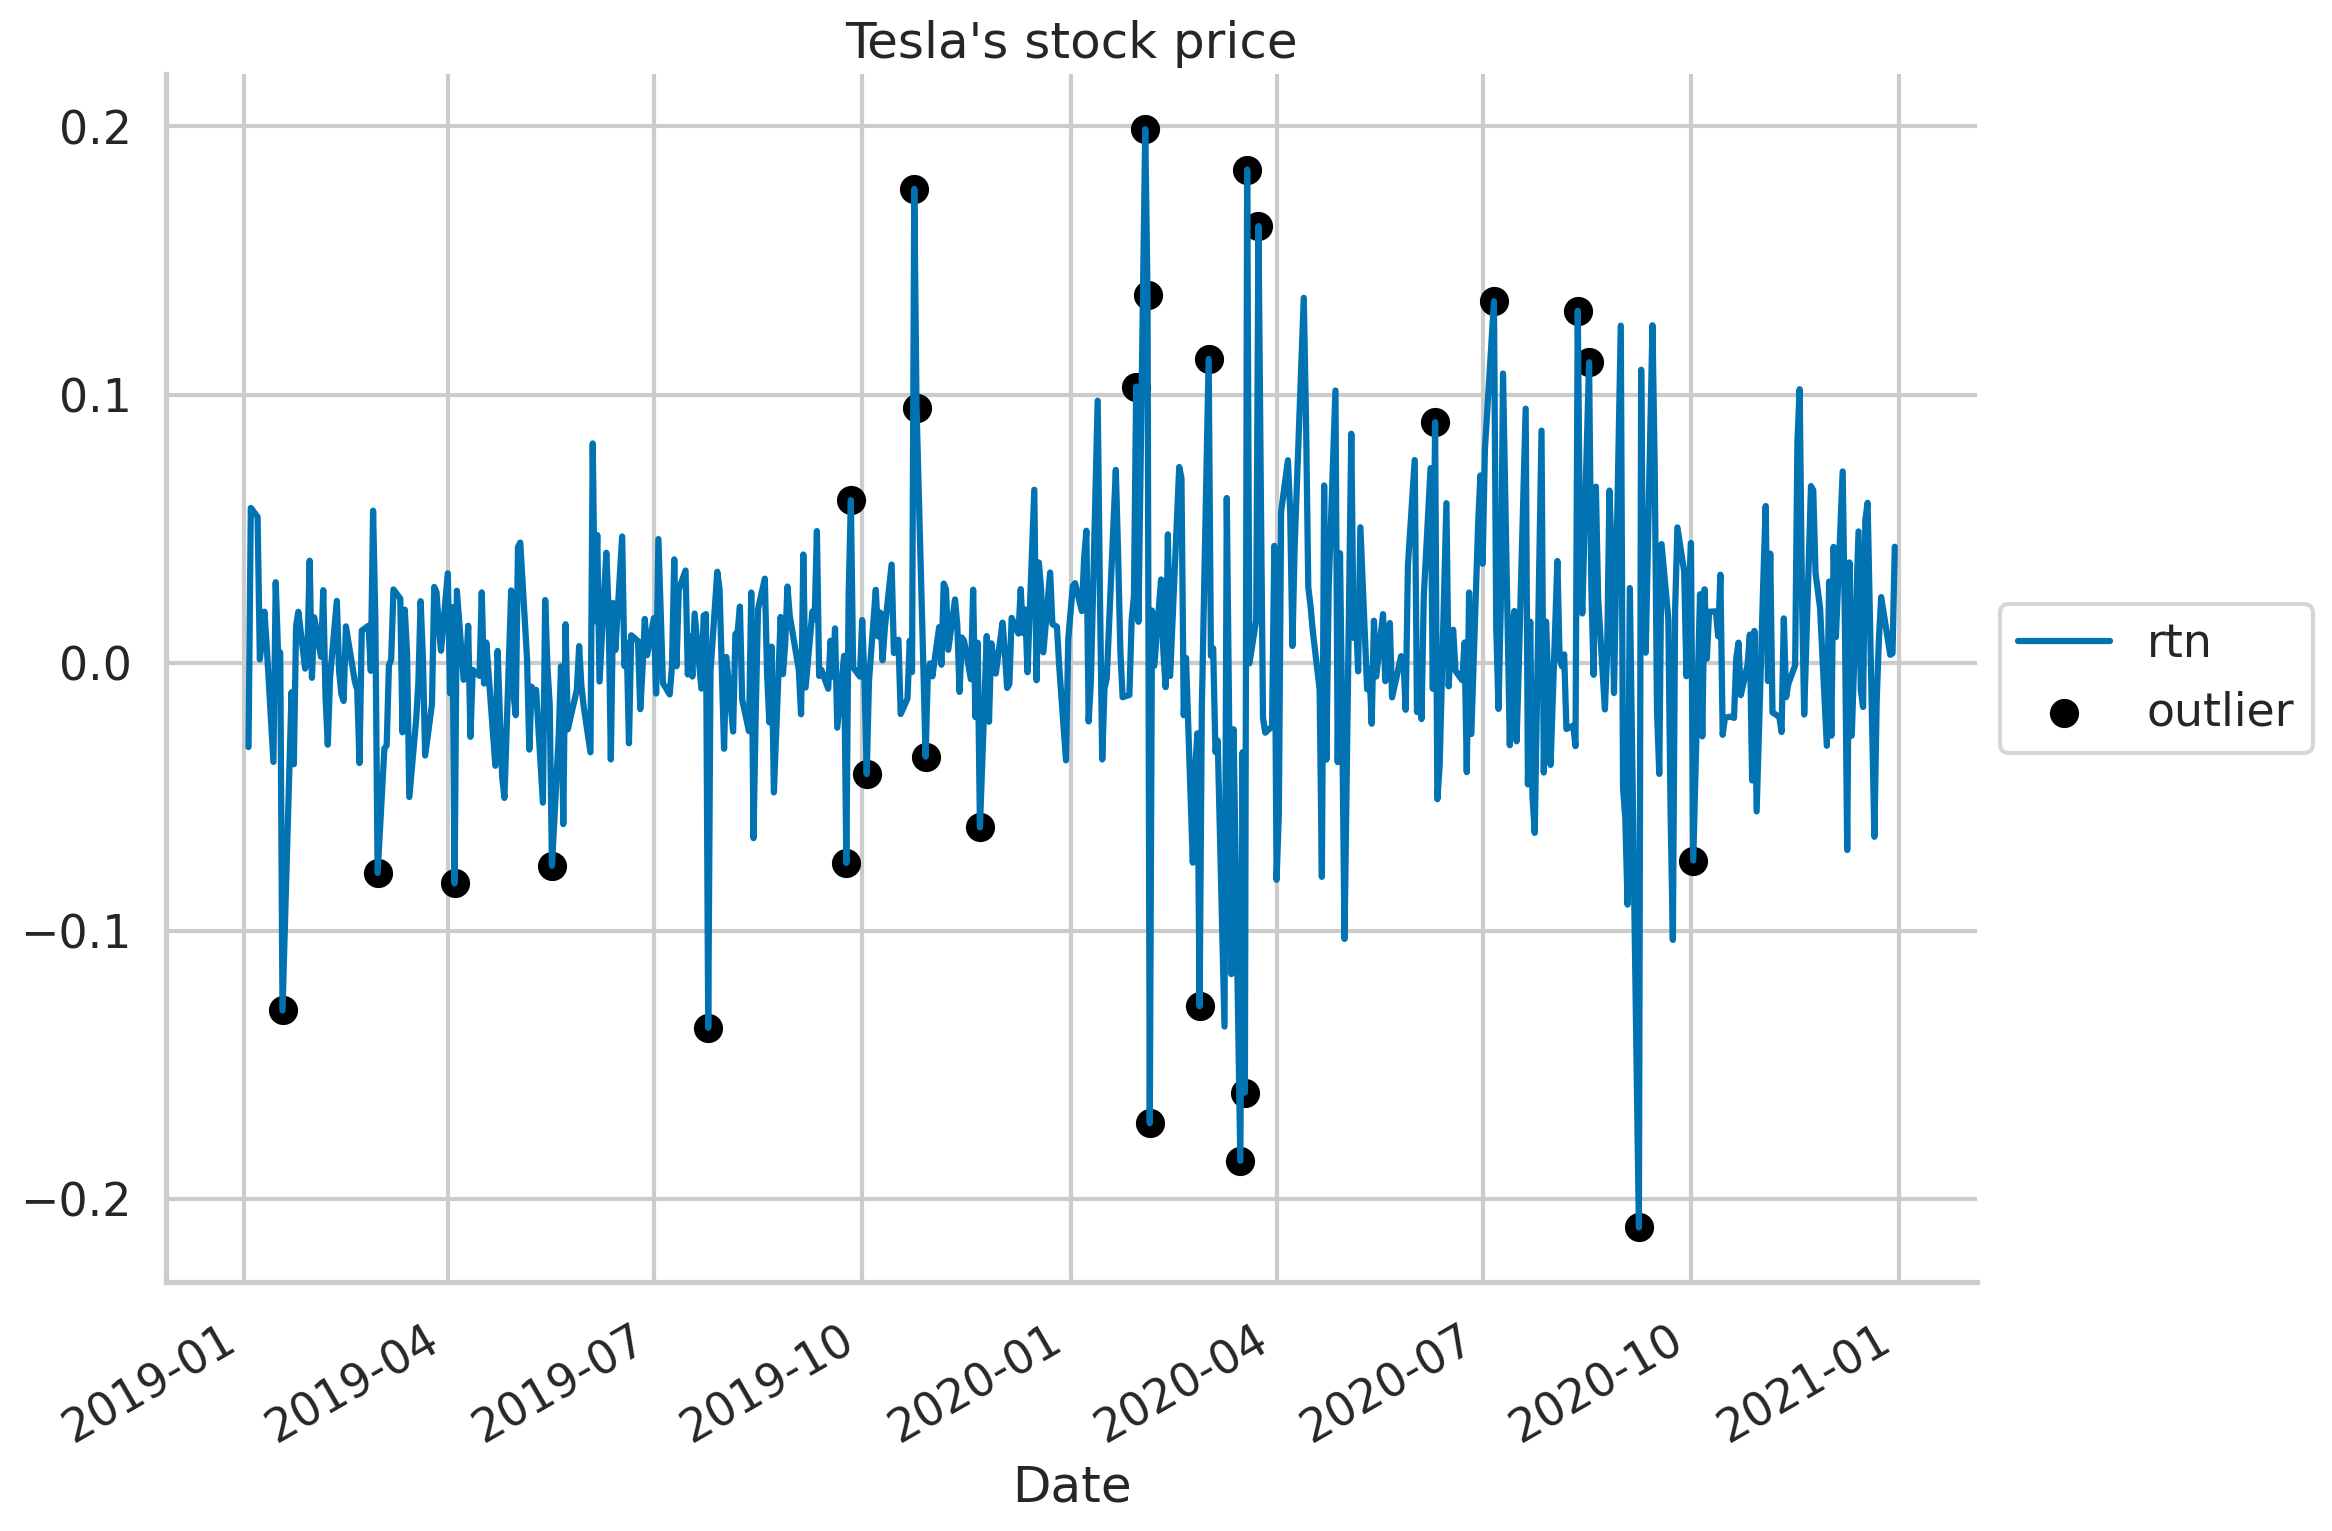

In [60]:
fig, ax = plt.subplots()

df[["rtn"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "rtn"],
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_2", dpi=200)

### There's more

1. Identify the outliers among the stock returns:

In [61]:
df["outlier_hampel"] = hampel_detector.fit_transform(df["rtn"])
df.head()

/usr/local/lib/python3.11/dist-packages/sktime/transformations/series/outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


,rtn,mean,std,upper,lower,outlier,outlier_hampel
Date,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,True,True
2019-01-03,-0.031472,NaN,NaN,NaN,NaN,False,False
2019-01-04,0.057697,NaN,NaN,NaN,NaN,False,False
2019-01-07,0.054361,NaN,NaN,NaN,NaN,False,False
2019-01-08,0.001164,NaN,NaN,NaN,NaN,False,False


2. Plot Tesla's daily returns and mark the outliers:

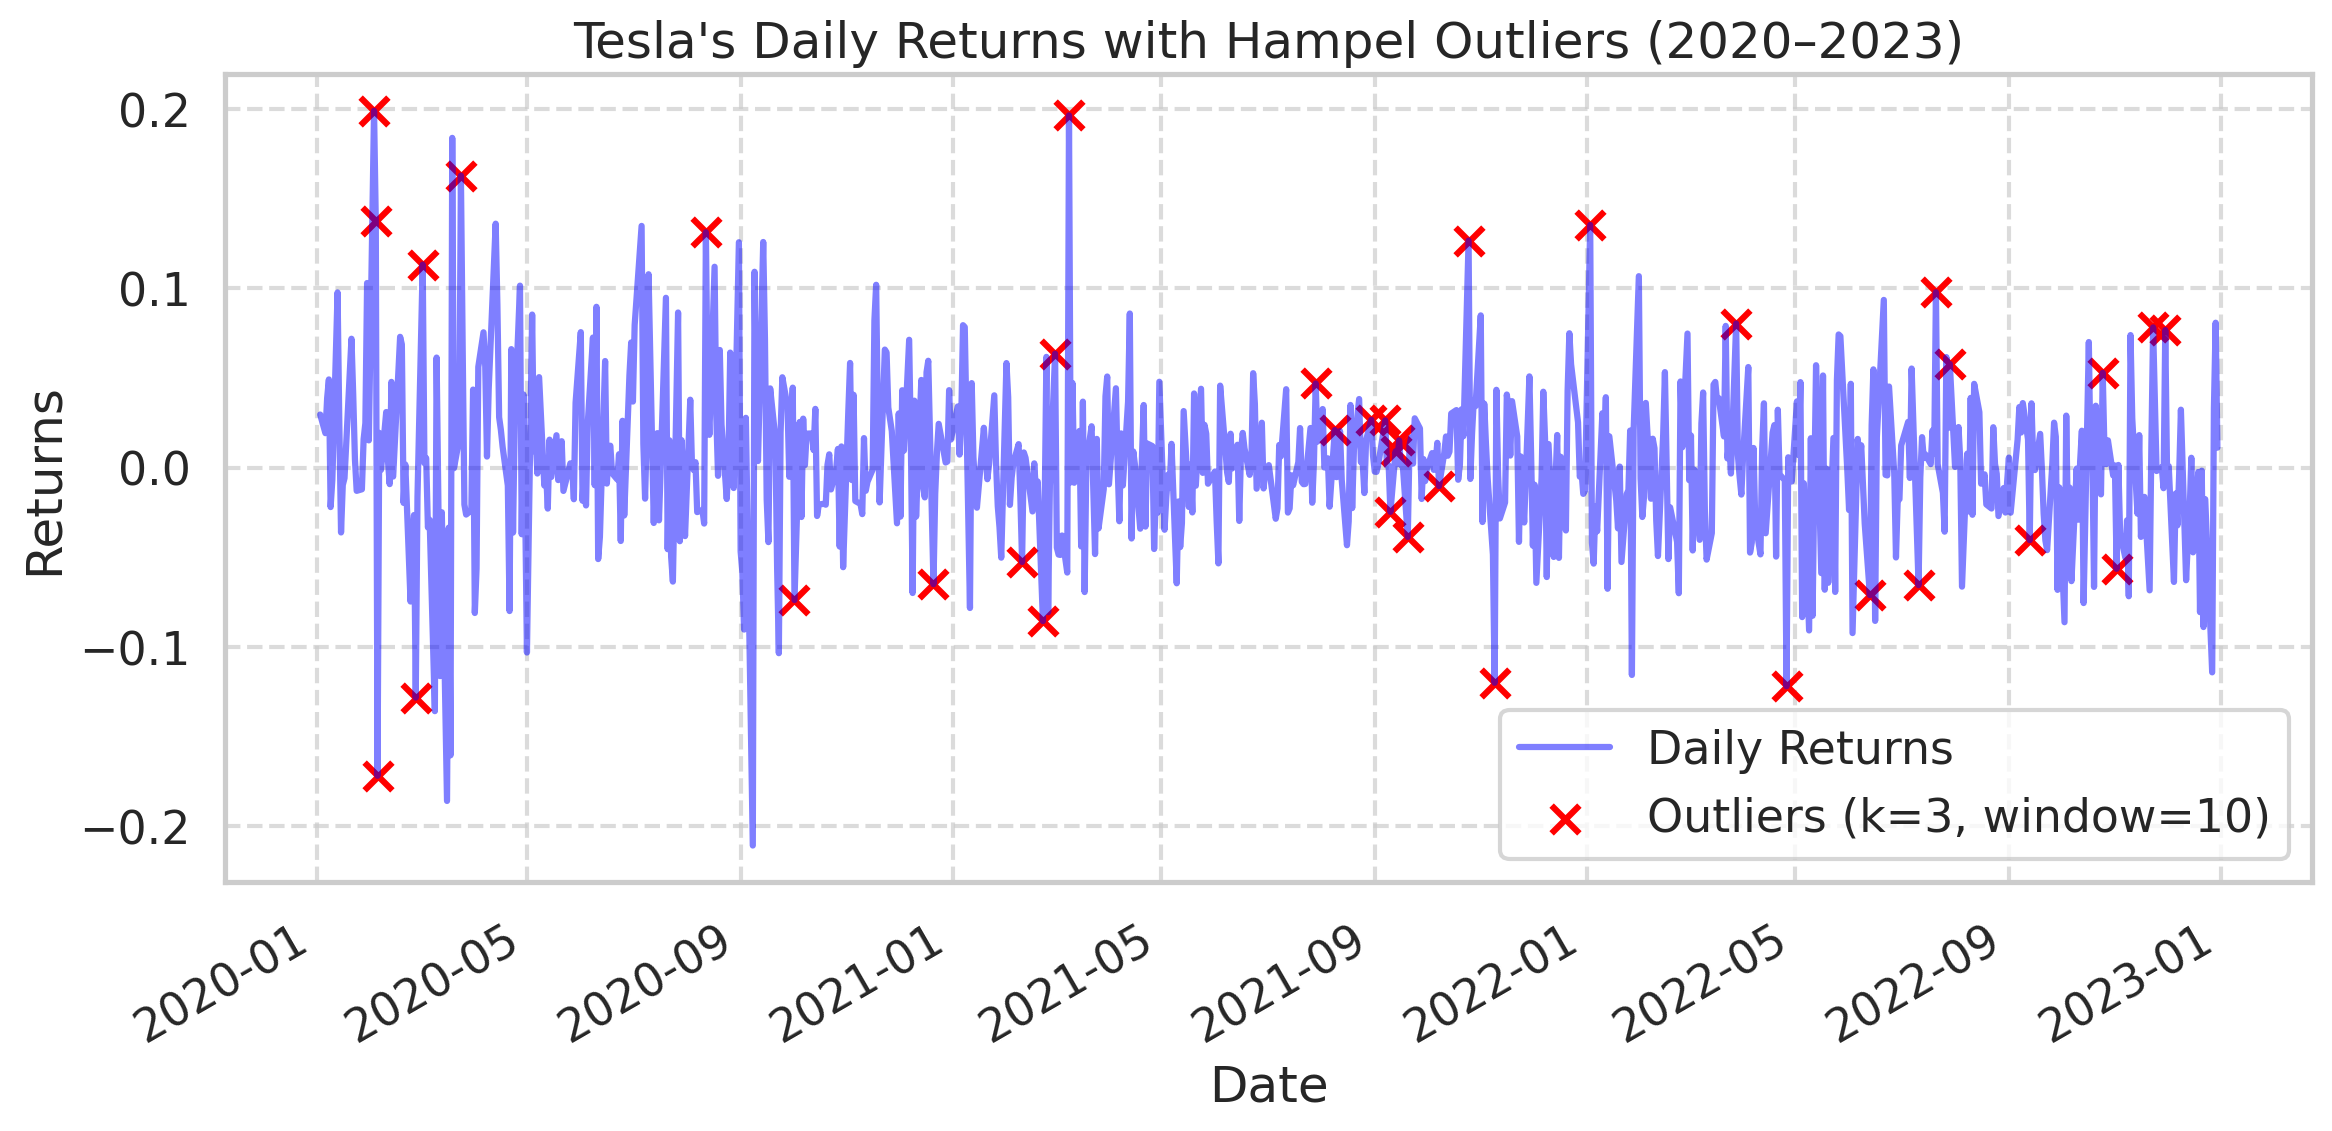

In [62]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

# 1. Download Tesla's stock data (2020–2023)
df = yf.download("TSLA", start="2020-01-01", end="2023-01-01", progress=False)

# 2. Calculate daily returns if not already present
if "rtn" not in df.columns:
    df["rtn"] = df["Close"].pct_change()  # Daily returns
    df = df[["rtn"]].dropna()  # Keep only returns and drop NaN

# 3. Hampel Detector Class (Scikit-learn compatible)
class HampelDetector(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, k=3):
        self.window = window
        self.k = k

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        median = X.rolling(window=self.window, center=True).median()
        mad = 1.4826 * np.abs(X - median).rolling(window=self.window, center=True).median()
        outliers = np.abs(X - median) > (self.k * mad)
        return outliers.astype(int)

# 4. Detect outliers (window=10, k=3)
hampel_detector = HampelDetector(window=10, k=3)
df["outlier_hampel"] = hampel_detector.fit_transform(df["rtn"])

# 5. Plot returns and outliers
fig, ax = plt.subplots(figsize=(12, 6))

# Daily returns
df["rtn"].plot(ax=ax, color="blue", alpha=0.5, label="Daily Returns")

# Outliers (highlighted in red)
outliers = df[df["outlier_hampel"] == 1]
ax.scatter(outliers.index, outliers["rtn"], color="red",
           label=f"Outliers (k=3, window=10)", marker="x", s=100)

# Formatting
ax.set_title("Tesla's Daily Returns with Hampel Outliers (2020–2023)")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

3. Investigate the overlap in outliers identified for the prices and returns:

In [63]:
df.columns

MultiIndex([(           'rtn', ''),
            ('outlier_hampel', '')],
           names=['Price', 'Ticker'])

##Задание 2.
Исследовать зависимость количества выбросов, определяемых фильтром Hampel от параметра `window_length = np.arange(5, 30, 5)`


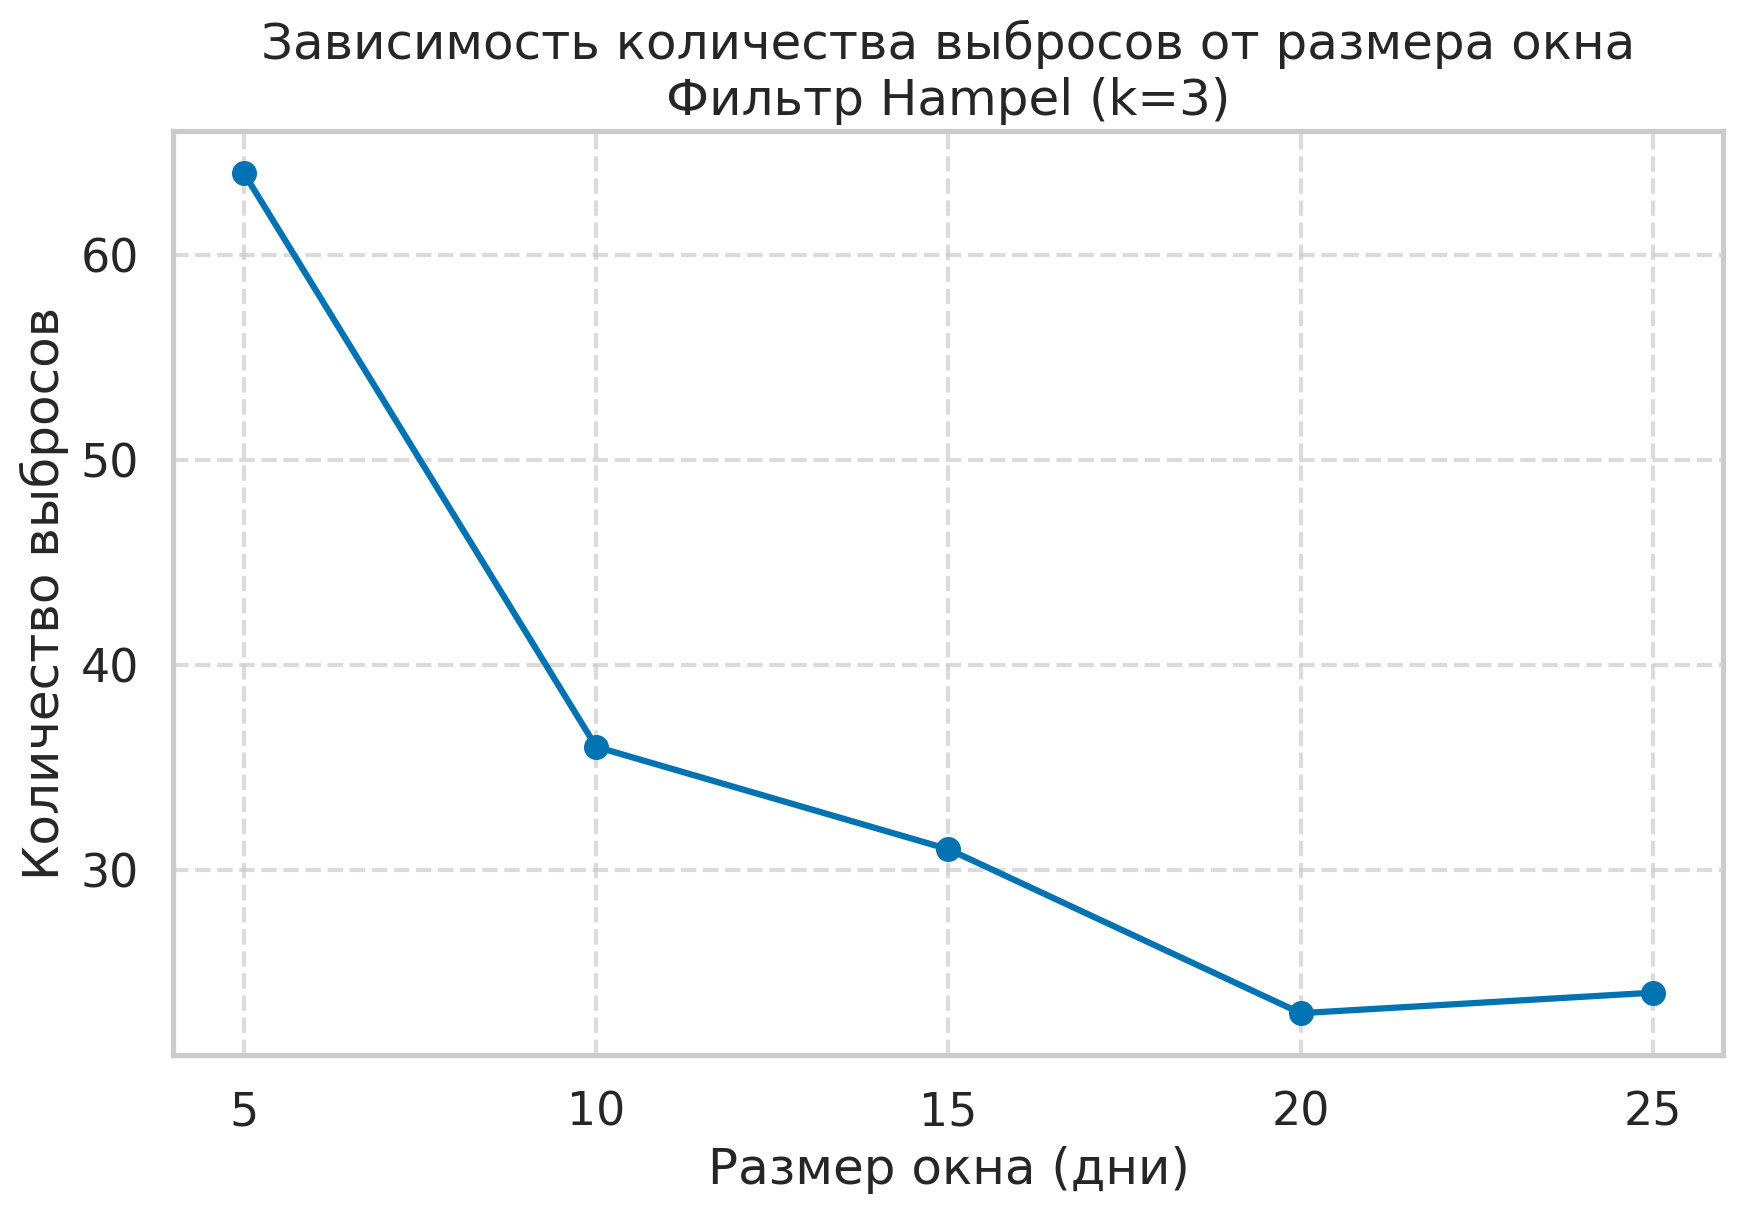


Результаты анализа:
 window  outliers percentage
      5        64      8.47%
     10        36      4.76%
     15        31      4.10%
     20        23      3.04%
     25        24      3.17%


In [64]:
# 1. Загрузка данных
df2 = yf.download("TSLA", start="2020-01-01", end="2023-01-01", progress=False)
df2["rtn"] = df2["Close"].pct_change().dropna()

# 2. Класс Hampel-фильтра
class HampelDetector:
    def __init__(self, window=5, k=3):
        self.window = window
        self.k = k

    def detect(self, series):
        median = series.rolling(window=self.window, center=True).median()
        mad = 1.4826 * (series - median).abs().rolling(window=self.window, center=True).median()
        return ((series - median).abs() > (self.k * mad)).astype(int)

# 3. Анализ для разных размеров окон
window_lengths = np.arange(5, 30, 5)
results = []

for w in window_lengths:
    detector = HampelDetector(window=w)
    outliers = detector.detect(df2["rtn"])
    results.append({
        'window': w,
        'outliers': outliers.sum(),
        'percentage': f"{outliers.mean()*100:.2f}%"
    })

# 4. Визуализация результатов
result_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(result_df['window'], result_df['outliers'], 'bo-', markersize=8)
plt.title('Зависимость количества выбросов от размера окна\nФильтр Hampel (k=3)')
plt.xlabel('Размер окна (дни)')
plt.ylabel('Количество выбросов')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(window_lengths)
plt.show()

# 5. Таблица результатов
print("\nРезультаты анализа:")
print(result_df.to_string(index=False))

## 4.3 Detecting changepoints in time series

### How to do it...

1. Import the libraries:

In [70]:
# Сначала установите основные зависимости вручную
!pip install pystan==2.19.1.1
!pip install prophet==1.1.1  # Современный аналог fbprophet

# Затем попробуйте установить Kats с пропуском зависимостей
!pip install kats --no-deps
!pip install pandas==1.3.5 statsmodels==0.12.2 scipy==1.7.3  # Вручную

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.0 MB/s eta 0

In [65]:
!pip install kats
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/multi_ts.csv

  Using cached kats-0.2.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached numpy-1.21.1.zip (10.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-1.3.5.tar.gz (4.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.6.1.tar.gz (27.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached statsmodels-0.12.2.tar.gz (17.5 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run su

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Цена акций Apple (AAPL)')
plt.title('Динамика стоимости акций Apple (2020-2022)')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.legend()
plt.grid()
plt.show()

KeyError: 'Price'

<Figure size 1200x600 with 0 Axes>

In [ ]:
import yfinance as yf
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

2. Download Apple's stock price from 2020:

In [ ]:
df = yf.download("AAPL",
                 start="2020-01-01",
                 end="2020-12-31",
                 progress=False)
df["Adj Close"].plot(title="Apple's stock in 2020");

3. Keep only the adjusted close price, reset the index and rename the columns:

In [ ]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

4. Convert the DataFrame into a `TimeSeriesData` object:

In [ ]:
tsd = TimeSeriesData(df)

5. Instantiate and run the changepoint detector:

In [ ]:
cusum_detector = CUSUMDetector(tsd)
change_points = cusum_detector.detector(
    change_directions=["increase"]
)
cusum_detector.plot(change_points)

6. Investigate the detected changepoint in more detail:

In [ ]:
point, meta = change_points[0]
point

In [ ]:
meta.__dict__

### There's more

1. Narrow down the window in which we want to search for the changepoint:

In [ ]:
change_points = cusum_detector.detector(change_directions=["increase"],
                                        interest_window=[200, 250])
cusum_detector.plot(change_points)


2. Use another algorithm to detect changepoints (`RobustStatDetector`):

In [ ]:
from kats.detectors.robust_stat_detection import RobustStatDetector

robust_detector = RobustStatDetector(tsd)
change_points = robust_detector.detector()
robust_detector.plot(change_points)

3. Change the `RobustStatDetector`'s default arguments:

In [ ]:
robust_detector = RobustStatDetector(tsd)
changepoints = robust_detector.detector(p_value_cutoff = 0.01, comparison_window=-5)
robust_detector.plot(changepoints)

## 4.4 Detecting trends in time series

### How to do it...

1. Import the libraries:

In [ ]:
import yfinance as yf
from kats.consts import TimeSeriesData
from kats.detectors.trend_mk import MKDetector

2. Download NVIDIA's stock prices from 2020:

In [ ]:
df = yf.download("NVDA",
                 start="2020-01-01",
                 end="2020-12-31",
                 progress=False)
df["Adj Close"].plot(title="NVIDIA's stock in 2020");

3. Keep only the adjusted close price, reset the index and rename the columns:

In [ ]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

4. Convert the DataFrame into a `TimeSeriesData` object:

In [ ]:
tsd = TimeSeriesData(df)

5. Instantiate and run the trend detector:

In [ ]:
trend_detector = MKDetector(tsd, threshold=0.9)
time_points = trend_detector.detector(
    direction="up",
    window_size=30
)

6. Plot the detected time points:

In [ ]:
trend_detector.plot(time_points)

7. Investigate the detected points in more detail:

In [ ]:
len(time_points)

Inspect a single time point:

In [ ]:
cp, meta = time_points[0]

In [ ]:
cp

In [ ]:
meta.__dict__

## 4.5 Detecting patterns in a time series using the Hurst exponent

### How to do it...

1. Import the libraries:

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Download S&P 500's historical prices from the years 2000-2019:

In [ ]:
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2019-12-31",
                 progress=False)
df["Close"].plot(title="S&P 500 (years 2000-2019)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_9", dpi=200);

3. Define a function calculating the Hurst exponent:

In [ ]:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""

    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

4. Calculate the values of the Hurst exponent using different values for the `max_lag` parameter:

In [ ]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

5. Narrow down the data to the years 2005-2007 and calculate the exponents one more time:

In [ ]:
df.loc["2005":"2007", "Close"].plot(title="S&P 500 (years 2005-2007)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_10", dpi=200);

In [ ]:
shorter_series = df.loc["2005":"2007", "Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

## 4.6 Investigating stylized facts of asset returns

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 data and calculate the returns:

In [ ]:
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2020-12-31",
                 progress=False)

df = df[["Close"]].rename(
    columns={"Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()
df

In [ ]:
df.columns = ['adj_close', 'log_rtn']
df.head()

#### Fact 1 - Non-Gaussian distribution of returns

1. Calculate the Normal PDF using the mean and standard deviation of the observed returns:

In [ ]:
r_range = np.linspace(min(df["log_rtn"]),
                      max(df["log_rtn"]),
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plot the histogram and the Q-Q Plot:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False,
             norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of S&P 500 returns",
                fontsize=16)
ax[0].plot(r_range, norm_pdf, "g", lw=2,
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

3. Print the summary statistics of the log returns:

In [ ]:
jb_test = scs.jarque_bera(df["log_rtn"].values)

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.4f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}")
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")

#### Fact 2 - Volatility Clustering

1. Run the following code to visualize the log returns series:

In [ ]:
(
    df["log_rtn"]
    .plot(title="Daily S&P 500 returns", figsize=(10, 6))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

#### Fact 3 - Absence of autocorrelation in returns

1. Define the parameters for creating the autocorrelation plots:

In [ ]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

In [ ]:
acf = smt.graphics.plot_acf(df["log_rtn"],
                            lags=N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

1. Create the ACF plots:

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);

#### Fact 5 - Leverage effect

1. Calculate volatility measures as moving standard deviations

In [ ]:
df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()

2. Plot all the series:

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15),
                       sharex=True)

df["adj_close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_252"].plot(ax=ax[2], color="r",
                           label="Rolling Volatility 252d")
df["rolling_std_21"].plot(ax=ax[2], color="g",
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_15", dpi=200);

### There's more

1. Download and preprocess the prices of the S&P 500 and VIX:

In [ ]:
df = yf.download(["^GSPC", "^VIX"],
                 start="2000-01-01",
                 end="2020-12-31",
                 progress=False)
df = df[["Close"]]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={"^GSPC": "sp500", "^VIX": "vix"})

2. Calculate the log returns (we can just as well use percentage change-simple returns):

In [ ]:
df["log_rtn"] = np.log(df["sp500"] / df["sp500"].shift(1))
df["vol_rtn"] = np.log(df["vix"] / df["vix"].shift(1))
df.dropna(how="any", axis=0, inplace=True)

3. Plot a scatterplot with the returns on the axes and fit a regression line to identify the trend:

In [ ]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x="log_rtn", y="vol_rtn", data=df,
                 line_kws={"color": "red"})
ax.set(title=f"S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})",
       ylabel="VIX log returns",
       xlabel="S&P 500 log returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_16", dpi=200);

## Задание 3.
Исследовать доходность акций компании VIX эффект плеча (Leverage effect), автокорреляцию модуля и квадрата доходности, и на распределение по Гауссу и Джака Бера.

In [72]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

# Загрузка данных VIX (индекс волатильности) и S&P 500
vix = yf.download("^VIX", start="2010-01-01", end="2023-01-01")['Close']
sp500 = yf.download("^GSPC", start="2010-01-01", end="2023-01-01")['Close']

# Расчет логарифмической доходности
vix_returns = np.log(vix/vix.shift(1)).dropna()
sp500_returns = np.log(sp500/sp500.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


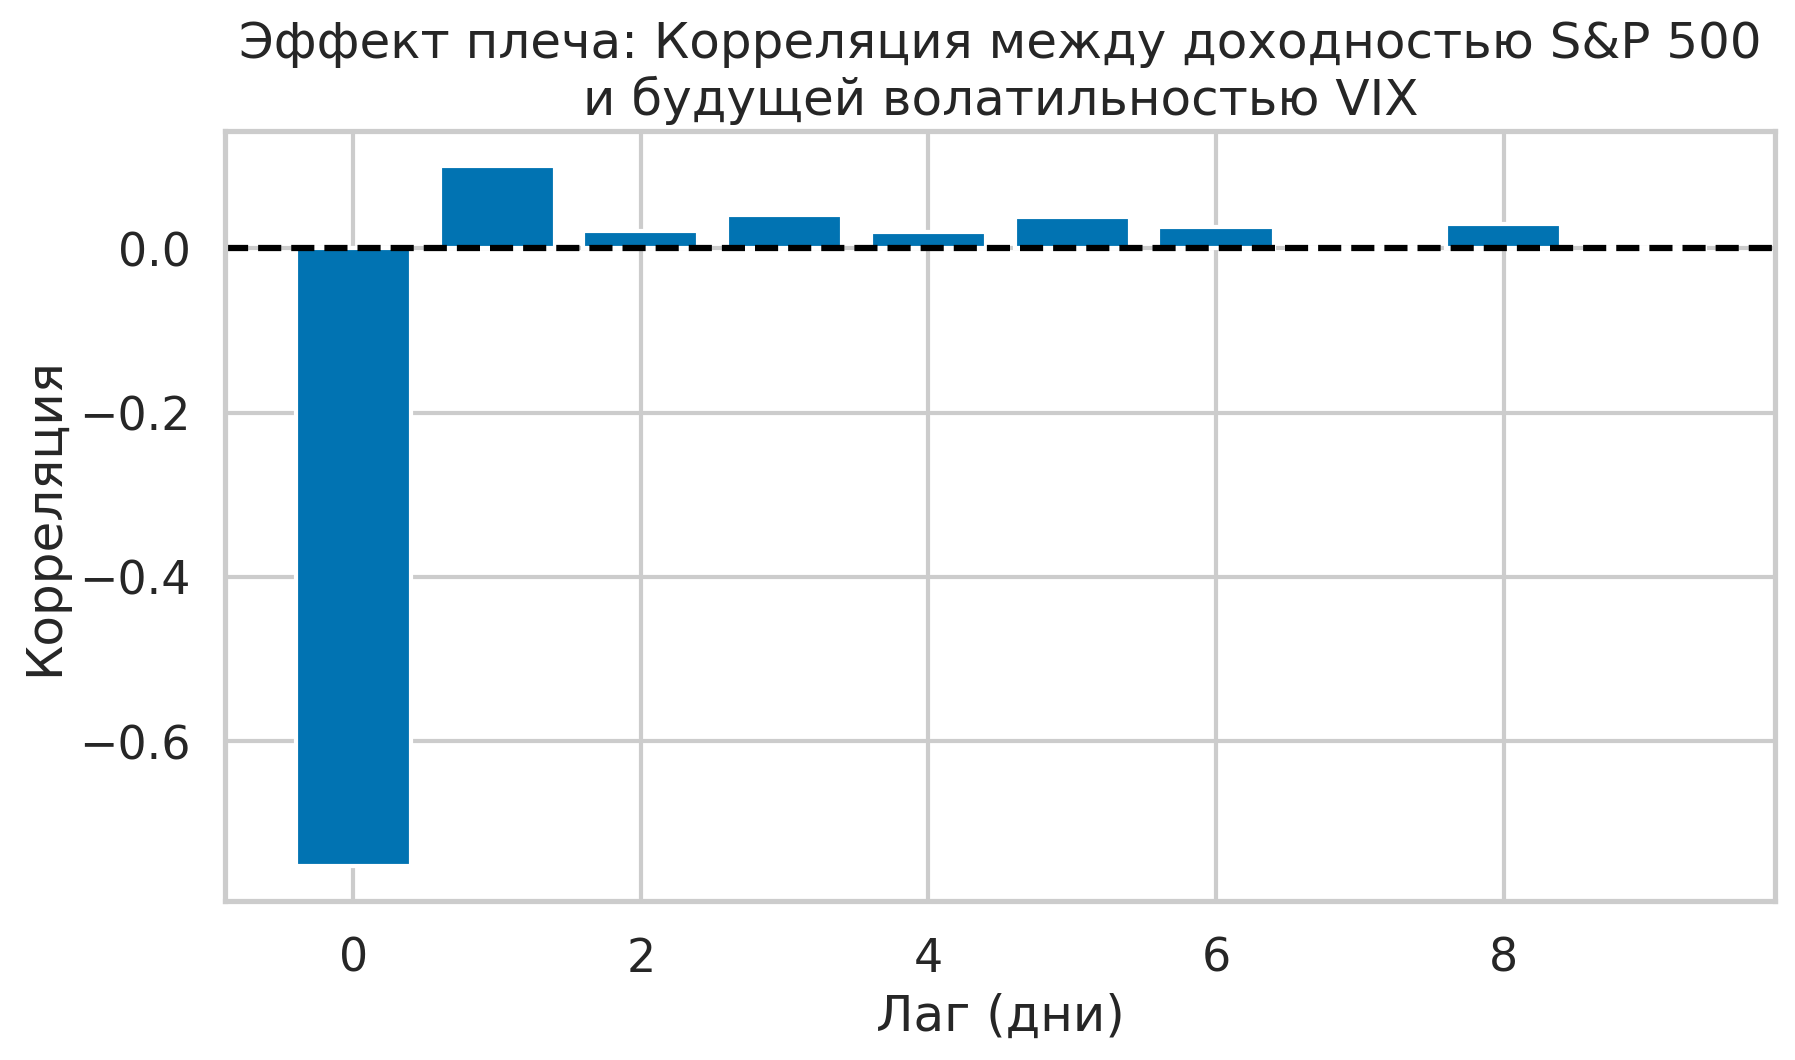

In [74]:
# Предполагаем, что данные загружены как:
# sp500 = yf.download('^GSPC')['Close']
# vix = yf.download('^VIX')['Close']

# Рассчитываем логарифмические доходности
sp500_returns = np.log(sp500 / sp500.shift(1)).dropna()
vix_returns = np.log(vix / vix.shift(1)).dropna()

# Убедимся, что работаем с Series (берем первый столбец если это DataFrame)
if isinstance(sp500_returns, pd.DataFrame):
    sp500_returns = sp500_returns.iloc[:, 0]
if isinstance(vix_returns, pd.DataFrame):
    vix_returns = vix_returns.iloc[:, 0]

# Расчет корреляции между текущей доходностью S&P 500 и будущей волатильностью
lags = 10
leverage_corrs = [sp500_returns.corr(vix_returns.shift(-lag)) for lag in range(lags)]

# Визуализация
plt.figure(figsize=(10,5))
plt.bar(range(lags), leverage_corrs)
plt.title('Эффект плеча: Корреляция между доходностью S&P 500\nи будущей волатильностью VIX')
plt.xlabel('Лаг (дни)')
plt.ylabel('Корреляция')
plt.axhline(0, color='black', linestyle='--')
plt.show()

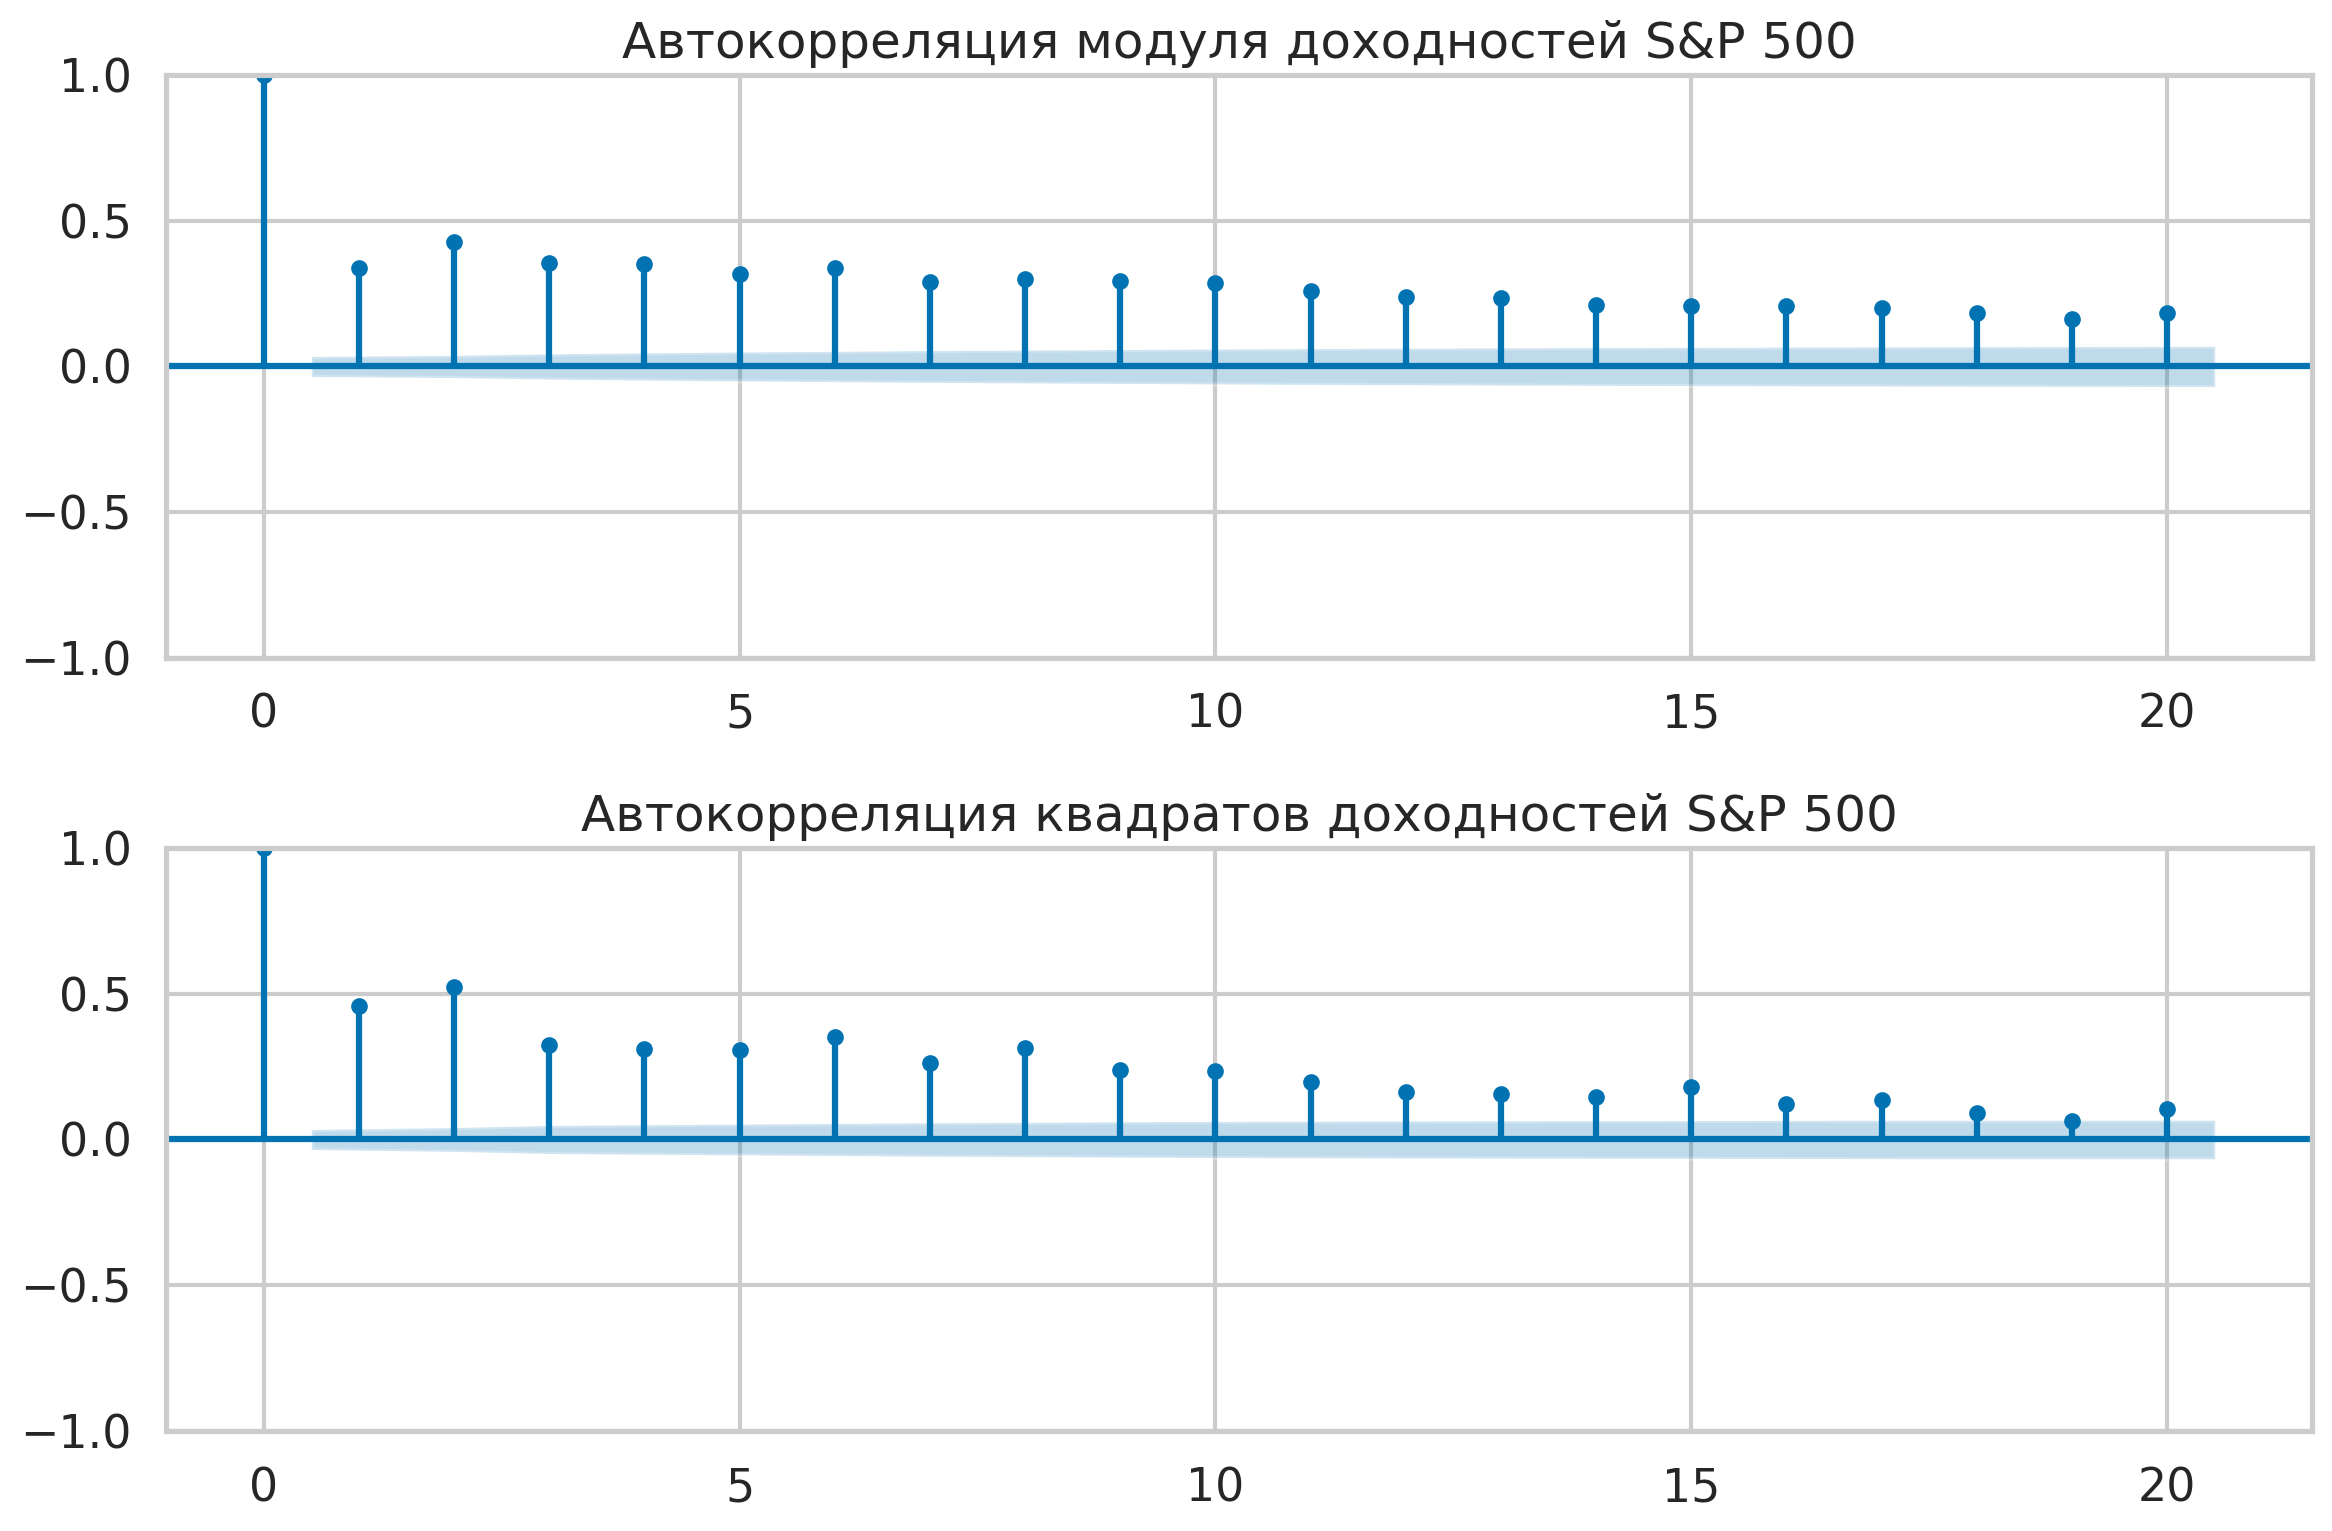

In [75]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Автокорреляция абсолютных доходностей
plot_acf(np.abs(sp500_returns), lags=20, ax=ax1, title='Автокорреляция модуля доходностей S&P 500')

# Автокорреляция квадратов доходностей
plot_acf(sp500_returns**2, lags=20, ax=ax2, title='Автокорреляция квадратов доходностей S&P 500')

plt.tight_layout()
plt.show()

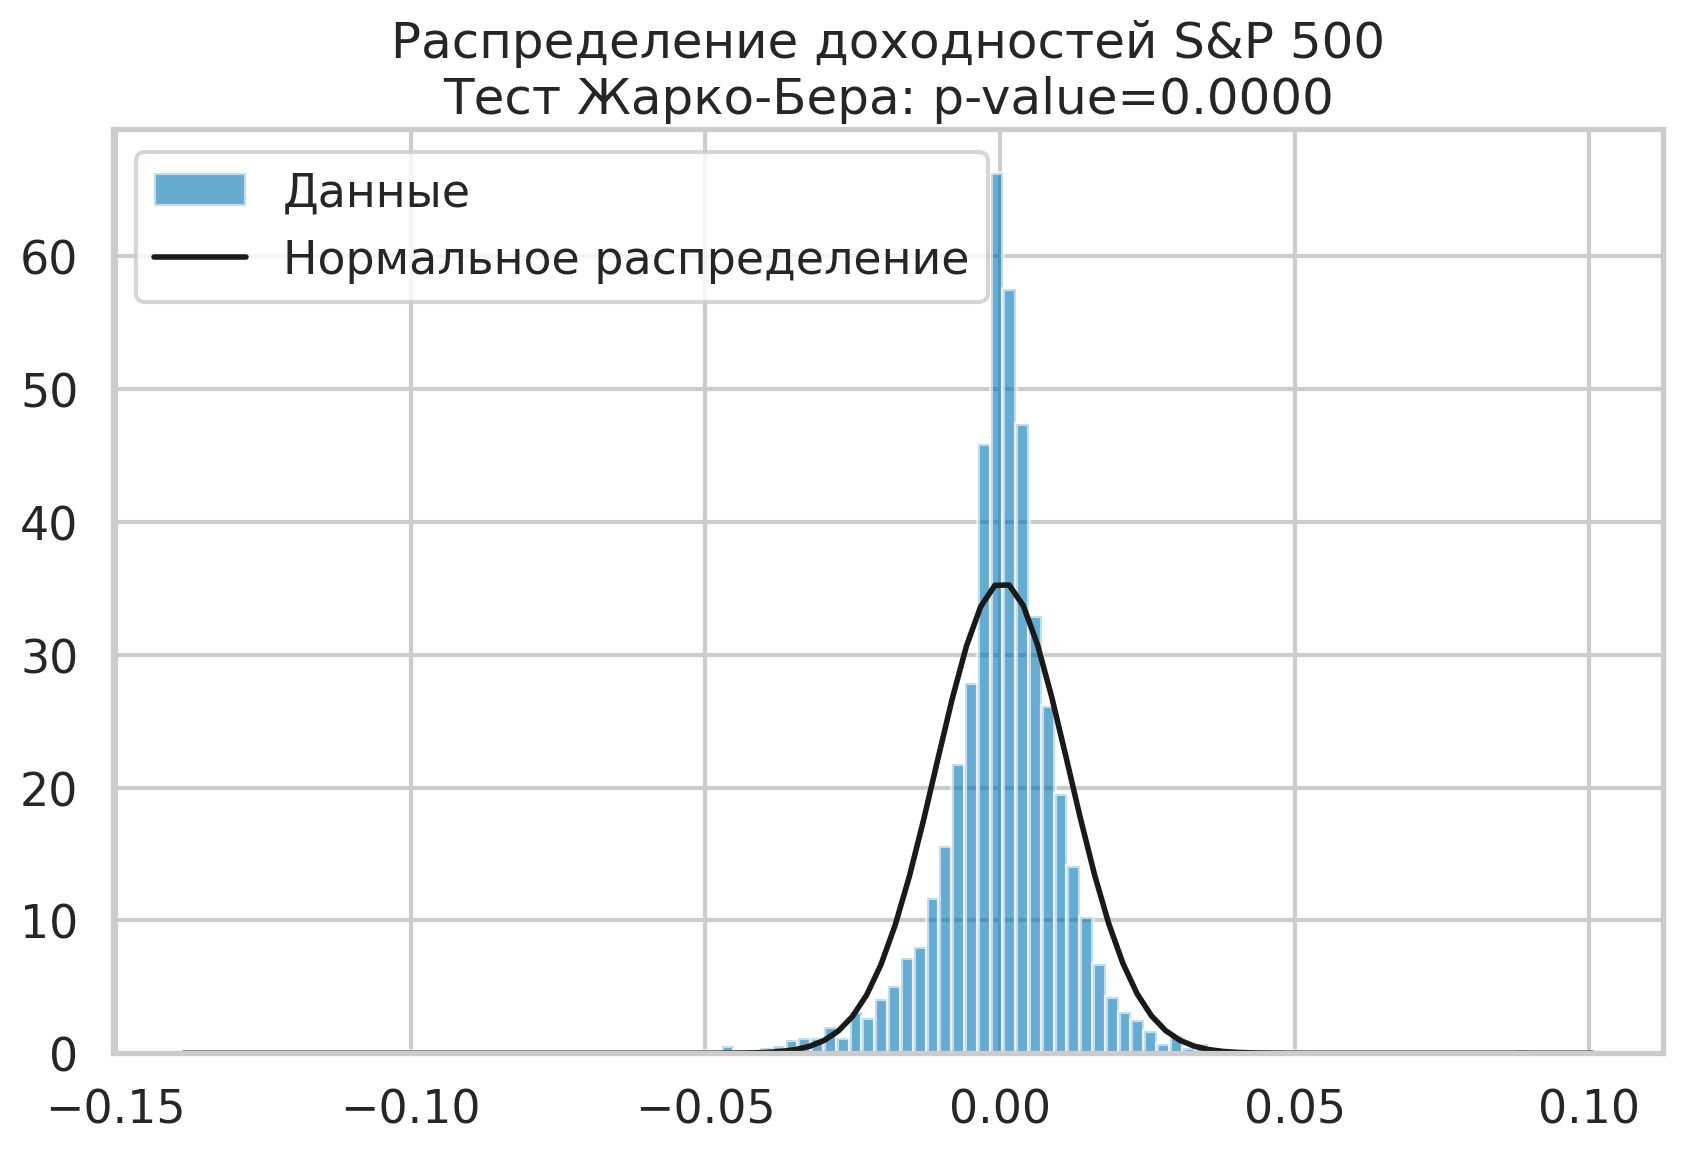

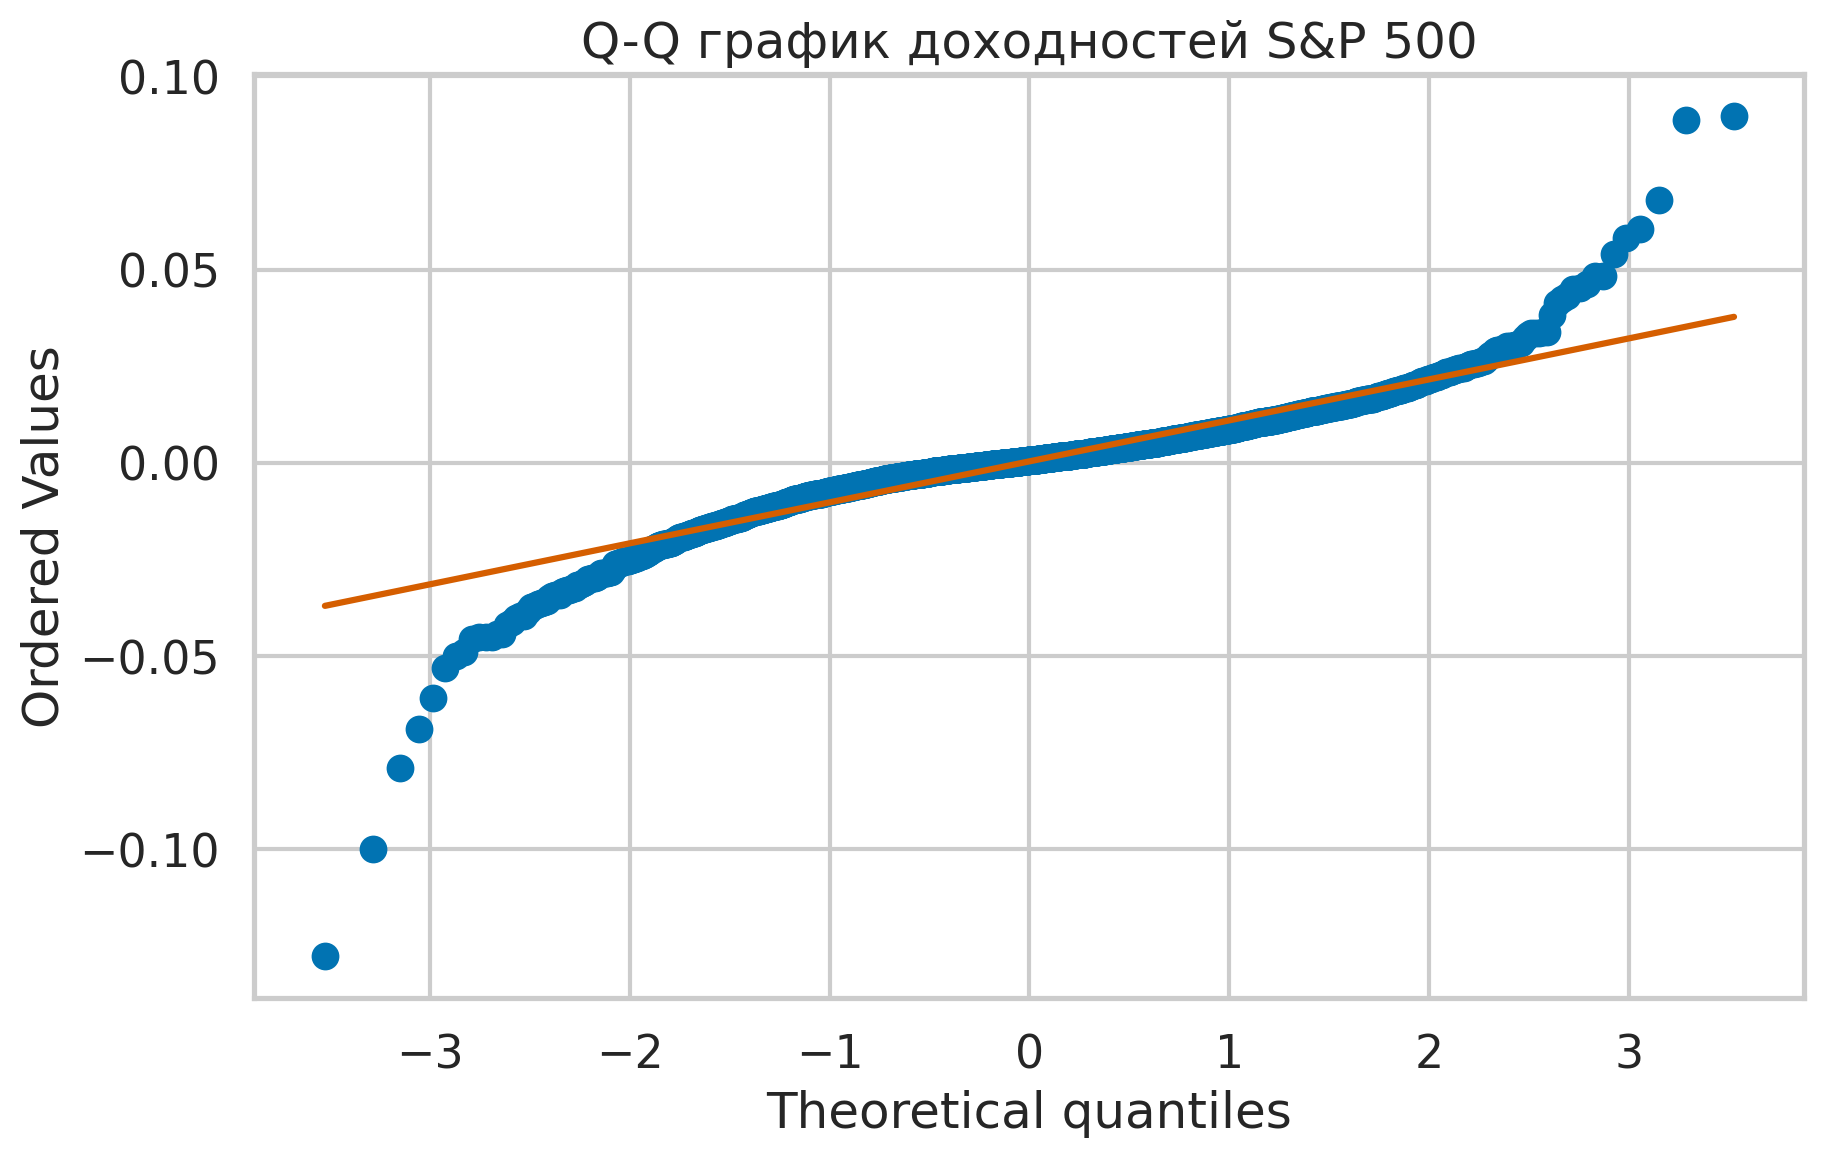

In [76]:
# Гистограмма с нормальным распределением
plt.figure(figsize=(10,6))
plt.hist(sp500_returns, bins=100, density=True, alpha=0.6, label='Данные')

# Нормальное распределение с теми же параметрами
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = sp500_returns.mean(), sp500_returns.std()
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Нормальное распределение')

# Тест Жарко-Бера
jb_test = stats.jarque_bera(sp500_returns)
plt.title(f'Распределение доходностей S&P 500\nТест Жарко-Бера: p-value={jb_test[1]:.4f}')
plt.legend()
plt.show()

# Квантиль-квантиль график
plt.figure(figsize=(10,6))
stats.probplot(sp500_returns, dist="norm", plot=plt)
plt.title('Q-Q график доходностей S&P 500')
plt.show()